# Setup

In [1]:
import sys
sys.path.append('/mnt/c/Users/Arnisa/Desktop/MP/mp-tl-study')
from functions.visualization_utils import *

## Load Data

In [33]:
# load baselines: filename!!
with open('results/cifarstyle_baselines_freeze_True_pool_True_random.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]

# load results; filename
with open('results/cifarstyle_fashion_random.json', 'r') as f:
    results = json.load(f)

# Run this if the first element of the results is the PARAMS dict
params = results[0]
results = results[1:]
# if not, initialize a params dict -see 3. Init params

data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,0.866667,0.817500
1,0.001,0.001,-1,1,1.000000,0.916278
2,0.001,0.001,-1,2,0.933333,0.872667
3,0.001,0.001,-1,3,1.000000,0.894389
4,0.001,0.001,-1,4,1.000000,0.882167


In [3]:
# Filter the baselines to these percentages: 0.001, 0.01, 0.1, 0.5, 1.0
# because there are some extra percentages
baselines = [result for result in baselines if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]

results = [result for result in results if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]
data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': col,
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,0.866667,0.810000
1,0.001,0.001,-1,1,0.933333,0.789000
2,0.001,0.001,-1,2,0.933333,0.808000
3,0.001,0.001,-1,3,0.866667,0.813000
4,0.001,0.001,-1,4,0.933333,0.807333


In [31]:
df_empirical = df.copy()

In [25]:
df_other = df.copy()

In [69]:
# OR LOAD ARI Scores
with open("results/ari_scores/cifar-style-fine-tuned.json", "r") as f:
    ari_scores_all = json.load(f)
df_ari = pd.DataFrame(ari_scores_all)

# Display the DataFrame (showing the first few rows for brevity)
df_ari.head()

,Percentage,Repeat,Num Samples,Layer,Max ARI Score,Avg ARI Score,Dataset,Split
0,0.001,0,0,conv0,63.0,33.236210,Fine-tune,Train
1,0.001,0,0,conv1,63.0,33.768572,Fine-tune,Train
2,0.001,0,0,conv2,63.0,33.920905,Fine-tune,Train
3,0.001,0,0,conv3,63.0,33.620669,Fine-tune,Train
4,0.001,0,0,conv4,63.0,34.019357,Fine-tune,Train


# 1. The plots
See the documentation (mp-tl-study/example_visualizations.ipynb) for a full list of supported visualizations

### Experimental Plots

/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther

Freeze = True, Reinitialize = True, Pooling = True, Learning rate = 0.001


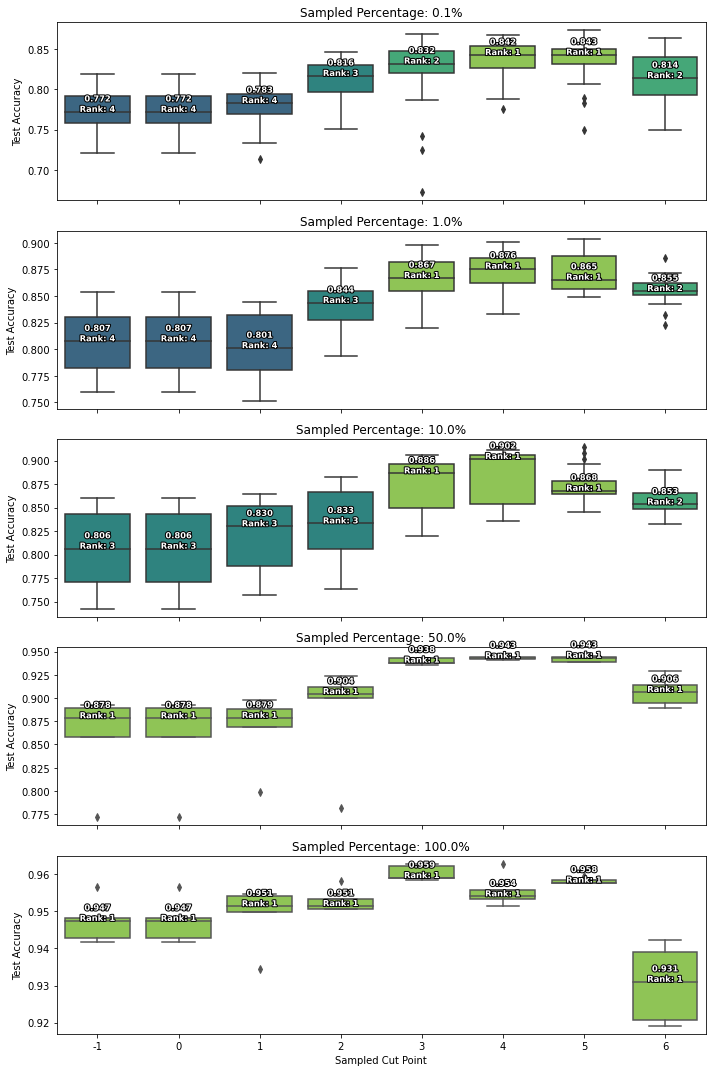

In [4]:
# run statistical tests below to get the df_rankings
_, df_rankings = get_rankings(df=df_empirical)
ranks_sorted = box_plot(df=df_empirical, rank_df=df_rankings, params=params, add_baseline=False)

/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


     Percentage  Cut Point 1  Cut Point 2  statistic   p_value  is_significant
0         0.001           -1            0      117.0  0.230361           False
1         0.001           -1            1       58.0  0.003781            True
2         0.001           -1            2       49.0  0.001453            True
3         0.001           -1            3      136.0  0.490786           False
4         0.001           -1            4       59.0  0.004175            True
..          ...          ...          ...        ...       ...             ...
135       1.000            3            5        0.0  0.062500           False
136       1.000            3            6        0.0  0.062500           False
137       1.000            4            5        1.0  0.125000           False
138       1.000            4            6        0.0  0.062500           False
139       1.000            5            6        0.0  0.062500           False

[140 rows x 6 columns]
Freeze = True, Reinitialize 

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

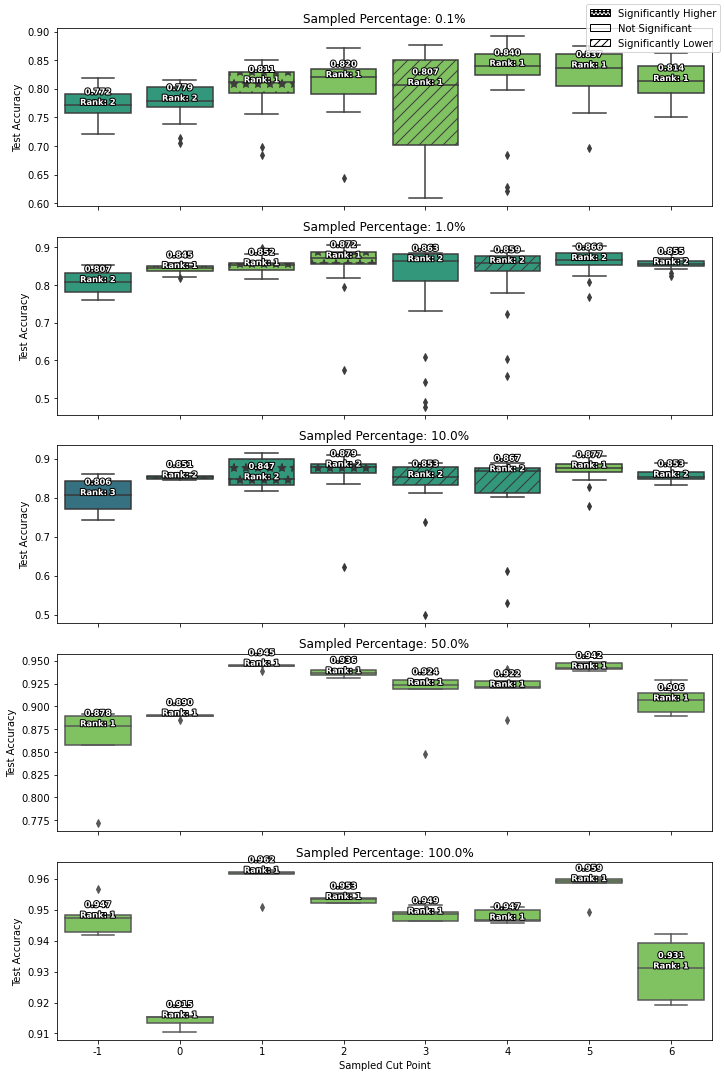

In [19]:
# run statistical tests below to get the df_rankings
_, df_rankings = get_rankings(df=df_other)
df_wilcoxon_pairwise = pairwise_comparison_multiple_plots(df_empirical, df_other)
stats_empirical = df_empirical.groupby(['Percentage', col]).agg({
    'Test Accuracy': 'mean',  # Add more columns/statistics as needed
})
stats_empirical = stats_empirical.reset_index()
stats_empirical.rename(columns={'Test Accuracy': 'Mean Test Accuracy'}, inplace=True)

stats_other = df_other.groupby(['Percentage', col]).agg({
    'Test Accuracy': 'mean',  # Add more columns/statistics as needed
})
stats_other = stats_other.reset_index()
stats_other.rename(columns={'Test Accuracy': 'Mean Test Accuracy'}, inplace=True)
# create df_rankings_empirical and df_rankings_truncated, where if one is significantly different from each other we compare the mean_test_acc of both, and the one which is bigger is ranked 1, the lower is rank 3, and if they are not significantly different they ar eboth rank 2

df_rankings_empirical = stats_empirical.copy()
df_rankings_other = stats_other.copy()

# in a for loop, compare the is_significant of two dataframes
for i in range(len(df_wilcoxon_pairwise)):
    if df_wilcoxon_pairwise.iloc[i]['is_significant']:
        if stats_empirical.iloc[i]['Mean Test Accuracy'] > df_rankings_other.iloc[i]['Mean Test Accuracy']:
            df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 8
            df_rankings_other.loc[i, 'Mean Test Accuracy'] = 1
        else:
            df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 1
            df_rankings_other.loc[i, 'Mean Test Accuracy'] = 8
    else:
        df_rankings_empirical.loc[i, 'Mean Test Accuracy'] = 5
        df_rankings_other.loc[i, 'Mean Test Accuracy'] = 5

df_rankings_empirical['rank'] = df_rankings_empirical['Mean Test Accuracy'].astype(int)
df_rankings_other['rank'] = df_rankings_other['Mean Test Accuracy'].astype(int)
box_plot(df=df_other, rank_df=df_rankings, params=params, pairwise_rank_df=df_rankings_other, pairwise=True)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

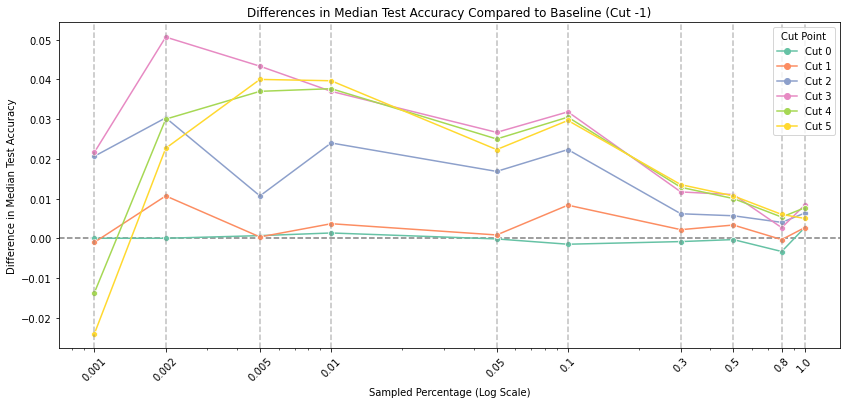

In [7]:
compare_to_baseline_line_plot(df)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

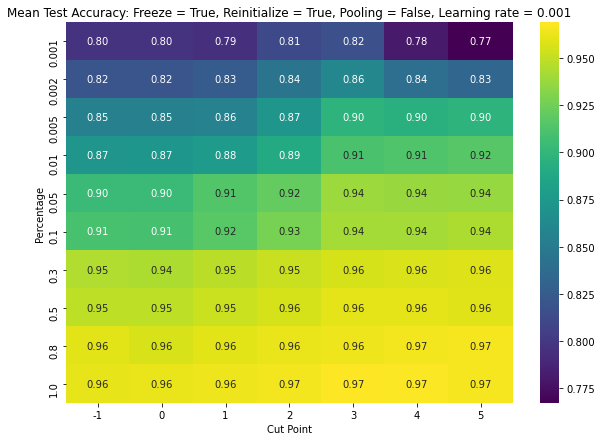

In [13]:
heatmap(df, params, figsize=(10,7))

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

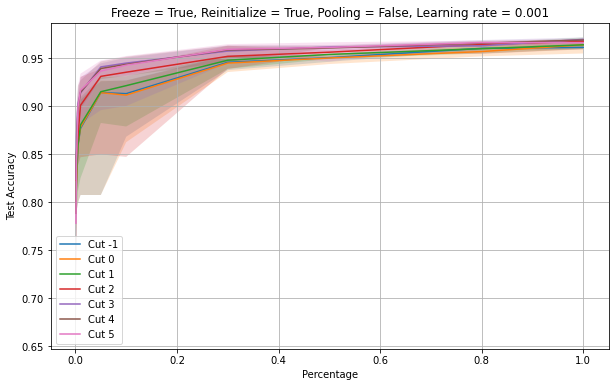

In [15]:
line_pilot_with_ranges(df, params)

### ARI Box Plots

In [47]:
df_ari

,Percentage,Repeat,Num Samples,Layer,Max ARI Score,Avg ARI Score,Dataset,Split
0,0.001,0,0,conv0,63.000000,33.236210,Fine-tune,Train
1,0.001,0,0,conv1,63.000000,33.768572,Fine-tune,Train
2,0.001,0,0,conv2,63.000000,33.920905,Fine-tune,Train
3,0.001,0,0,conv3,63.000000,33.620669,Fine-tune,Train
4,0.001,0,0,conv4,63.000000,34.019357,Fine-tune,Train
...,...,...,...,...,...,...,...,...
635,1.000,4,50,conv3,63.000000,30.673777,Fine-tune,Train
636,1.000,4,50,conv4,63.000000,30.067229,Fine-tune,Train
637,1.000,4,50,conv5,63.000000,31.667376,Fine-tune,Train
638,1.000,4,50,fc,44.931767,10.868286,Fine-tune,Train


In [80]:
def box_plot(params:dict, df:pd.DataFrame, 
                rank_df:pd.DataFrame, unique_ranks:list=None, color_palette:str="viridis", 
                pairwise_rank_df:pd.DataFrame=None, pairwise:bool=False, 
                ylim:float=None, yscale:str=None, figsize:tuple=None, 
                add_baseline:bool=False, tick_labels_dict:dict=None):
    # Creating subplots for each data percentage
    unique_percentages = df['Percentage'].unique()
    n_percentages = len(unique_percentages)

    if unique_ranks is None:
        unique_ranks = rank_df['rank'].unique()
    ranks_lim = unique_ranks.max()
    rank_color_map = {rank: ranks_lim+1-rank for rank in range(ranks_lim, 0, -1)}
    # print(rank_color_map)

    if figsize is None:
        figsize = (10, 3 * n_percentages)

    # Adjusting the subplot layout for better readability of median values
    fig, axes = plt.subplots(nrows=n_percentages, ncols=1, figsize=figsize, sharex=True)

    for i, percentage in enumerate(sorted(unique_percentages)):
        ax = axes[i]
        
        # Filtering data for each percentage
        df_subset = df[df['Percentage'] == percentage]

        # Custom coloring based on ranks sorted by median accuracy
        rank_subset = rank_df[rank_df['Percentage'] == percentage]
        ranks = rank_subset.set_index('Cut Point')['rank']
        if add_baseline:
            ranks.loc[-1] = ranks.loc[0]   
        ranks_sorted = ranks.sort_values(ascending=False)
        rank_txt_map = {rank:rank_id+1 for rank_id,rank in enumerate(sorted(list(np.unique(ranks))))}
        
        cut_color_map = {cut: rank_color_map[rank] for cut, rank in ranks_sorted.items()}
        cut_rank_map = {cut: rank for cut, rank in ranks_sorted.items()}
        color_palette = sns.color_palette(color_palette, len(rank_color_map)+1)
        palette = {cut: color_palette[color_id] for cut, color_id in cut_color_map.items()}

        ax = sns.boxplot(x='Cut Point', y='Test Accuracy', data=df_subset, ax=axes[i], palette=palette)
        
        if pairwise:
            # Custom coloring based on ranks sorted by median accuracy
            pairwise_rank_subset = pairwise_rank_df[pairwise_rank_df['Percentage'] == percentage]
            pairwise_ranks = pairwise_rank_subset.set_index('Cut Point')['rank']
            if add_baseline:
                pairwise_ranks.loc[-1] = pairwise_ranks.loc[0]   
            pairwise_ranks_sorted = pairwise_ranks.sort_values(ascending=False)

            rank_hatch_map = {1:"//", 5:None, 8:"*"}
            cut_hatch_map = {cut: rank_hatch_map[rank] for cut, rank in pairwise_ranks_sorted.items()}
            cuts = sorted(list(cut_hatch_map.keys()))
        
        # Apply hatching patterns
        if pairwise:
            for j, box in enumerate(ax.artists):
                cut = cuts[j]
                hatch = cut_hatch_map.get(cut, '')
                box.set_hatch(hatch)
                # box.set_edgecolor('white')

        # Annotating each boxplot with the median value for better contrast
        medians = df_subset.groupby(['Cut Point'])['Test Accuracy'].median().sort_index()
        for j, median in enumerate(medians):
            txt = f'{median:.3f}\nRank: {rank_txt_map[cut_rank_map[j-1]]}'
            text = axes[i].text(j, median, txt, horizontalalignment='center', size='small', color='white', weight='semibold')
            text.set_path_effects([patheffects.withStroke(linewidth=2, foreground="black")])

        axes[i].set_title(f'Sampled Percentage: {percentage*100}%')
        axes[i].set_xlabel('Layer')
        if ylim:
            axes[i].set_ylim(ylim, 1.0)
        if yscale:
            axes[i].set_yscale('log')

        if i == n_percentages - 1:
            axes[i].set_xlabel('Feature Extractor Layer')
        else:
            axes[i].set_xlabel('')
        axes[i].set_ylabel('Avg. ARI Score')

    if tick_labels_dict:
        final_ax = axes[-1]
        current_ticks = final_ax.get_xticks()
        final_ax.set_xticks(current_ticks)
        final_ax.set_xticklabels([tick_labels_dict.get(int(tick), tick) for tick in current_ticks])

    # Adding legend
    if pairwise:
        handles = [mpatches.Patch(fill=False, hatch="***", label='Significantly Higher'), 
                   mpatches.Patch(fill=False, hatch=None, label='Not Significant'), 
                   mpatches.Patch(fill=False, hatch="///", label='Significantly Lower')]
        fig.legend(handles=handles, loc='upper right')

    # Adding a super title -just print it out for the latex
    print(f'Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
    # fig.subplots_adjust(top=0.85)
    plt.tight_layout()

    return plt

In [57]:
def pairwise_comparison_experimental(df:pd.DataFrame, col:str="Cut Point"):
    df_differences = df

    def perform_wilcoxon_test(group, cut_point_1, cut_point_2):
        # print(cut_point_1, cut_point_2)
        data_1 = group[group[col] == cut_point_1][col]
        data_2 = group[group[col] == cut_point_2][col]

        # Ensure equal length by trimming or padding
        min_len = min(len(data_1), len(data_2))
        data_1, data_2 = data_1[:min_len], data_2[:min_len]
        try:
            stat, p_value = wilcoxon(data_1, data_2)
        except ValueError:
            stat, p_value = 0, 1
        # print(stat, p_value)
        return stat, p_value

    # Perform pairwise comparison for each sampled_percentage
    wilcoxon_pairwise_results = []

    for percentage in df_differences['Percentage'].unique():
        # print(percentage)
        group = df_differences[df_differences['Percentage'] == percentage]
        cut_points = group[col].unique()

        print(cut_points)
        for i in range(len(cut_points)):
            for j in range(i + 1, len(cut_points)):
                stat, p_value = perform_wilcoxon_test(group, cut_points[i], cut_points[j])
                wilcoxon_pairwise_results.append({
                    'Percentage': percentage,
                    'Cut Point 1': cut_points[i],
                    'Cut Point 2': cut_points[j],
                    'statistic': stat,
                    'p_value': p_value
                })

    # Converting the results to a DataFrame
    df_wilcoxon_pairwise = pd.DataFrame(wilcoxon_pairwise_results)
    print(df_wilcoxon_pairwise)
    # print(df_wilcoxon_pairwise)
    df_wilcoxon_pairwise["is_significant"] = df_wilcoxon_pairwise["p_value"] < 0.05
    
    return df_wilcoxon_pairwise

def find_in_nested_list(nested_list, key):
    for i, sublist in enumerate(nested_list):
        if key in sublist:
            return i
    return None

def group_cuts(df_wilcoxon_pairwise, cut_points):
    # create a list groups of tuples, containing the cut_points
    groups = result = [[cp] for cp in cut_points]
    skip = 1

    while skip < len(groups):
        cur = 0
        groups = result
        result = [groups[0]]
        
        cur = 0
        while cur+skip < len(groups):
            # print(cur, skip, groups)
            groups = sorted(groups, key=lambda x: x[0])
            group1 = groups[cur]
            group2 = groups[cur+skip]
            cur_res = find_in_nested_list(result, group1[0])
            if cur_res == None:
                result.append(group1)
                cur_res = -1
                
            if df_wilcoxon_pairwise[
                    (df_wilcoxon_pairwise['Cut Point 1'] == group1[0]) &
                    (df_wilcoxon_pairwise['Cut Point 2'] == group2[0]) &
                    (df_wilcoxon_pairwise['is_significant'] == False)].__len__() > 0: 
                # If the current number is similar to the previous, add it to the current group
                result[cur_res] += group2
            else:
                result.append(group2)
            cur += 1
            # print(result)
        skip += 1

        # make sure result includes all numbers
        for i in cut_points:
            try:
                if find_in_nested_list(result, i) == None:
                    list_id = find_in_nested_list(groups, i)
                    result.append(groups[list_id])
            except:
                print(result, groups, i)
    return result

def get_rankings(df: pd.DataFrame, col: str = "Cut Point"):
    # run statistical tests below to get the df_rankings
    df_wilcoxon_pairwise_all = pairwise_comparison_experimental(df=df, col=col)

    stats_all = df.groupby(['Percentage', col]).agg({
        'Test Accuracy': 'mean',  # Add more columns/statistics as needed
    })
    stats_all = stats_all.reset_index()
    # create empty col for stats_all called rank
    stats_all['rank'] = None

    for percentage in df['Percentage'].unique():
        # setup
        df_wilcoxon_pairwise = df_wilcoxon_pairwise_all[df_wilcoxon_pairwise_all["Percentage"] == percentage]
        # print(df_wilcoxon_pairwise[["Cut Point 1", "Cut Point 2", "is_significant"]])
        stats = stats_all[stats_all["Percentage"] == percentage]
        cut_points = stats[col].tolist()

        # print(percentage)
        groups = group_cuts(df_wilcoxon_pairwise, cut_points)
        
        # # Step 3: Rank the groups based on their mean test accuracy
        group_mean_accuracies = [(group, stats[stats[col].isin(group)]['Test Accuracy'].mean()) for group in groups]
        group_mean_accuracies.sort(key=lambda x: x[1], reverse=True)
        group_ranks = {frozenset(group): rank + 1 for rank, (group, _) in enumerate(group_mean_accuracies)}

        # stats_all["rank"] = rank of the group where stats_all["Cut Point"] in group and stats_all["Percentage"] == percentage
        for group, rank in group_ranks.items():
            stats_all.loc[
                (stats_all[col].isin(group)) &
                (stats_all['Percentage'] == percentage), "rank"] = rank
    return df_wilcoxon_pairwise_all, stats_all

In [78]:
map_to_cuts = {
    "input":0,
    "conv0":1,
    "conv1":2,
    "conv2":3,
    "conv3":4,
    "conv4":5,
    "conv5":6,
    "fc":-1
}

tick_labels_dict = {
    0: "Input",
    1: "Conv0",
    2: "Conv1",
    3: "Conv2",
    4: "Conv3",
    5: "Conv4",
    6: "Conv5",
    -1: "FC"
}

In [70]:
df_ari = df_ari[df_ari["Layer"].isin(map_to_cuts.keys())]

In [71]:
df_ari

,Percentage,Repeat,Num Samples,Layer,Max ARI Score,Avg ARI Score,Dataset,Split
0,0.001,0,0,conv0,63.000000,33.236210,Fine-tune,Train
1,0.001,0,0,conv1,63.000000,33.768572,Fine-tune,Train
2,0.001,0,0,conv2,63.000000,33.920905,Fine-tune,Train
3,0.001,0,0,conv3,63.000000,33.620669,Fine-tune,Train
4,0.001,0,0,conv4,63.000000,34.019357,Fine-tune,Train
...,...,...,...,...,...,...,...,...
635,1.000,4,50,conv3,63.000000,30.673777,Fine-tune,Train
636,1.000,4,50,conv4,63.000000,30.067229,Fine-tune,Train
637,1.000,4,50,conv5,63.000000,31.667376,Fine-tune,Train
638,1.000,4,50,fc,44.931767,10.868286,Fine-tune,Train


In [72]:
df_ari["Cut Point"] = df_ari["Layer"].map(map_to_cuts)

In [73]:
df_ari['Test Accuracy'] = df_ari['Avg ARI Score']

In [53]:
df_ari

,Percentage,Repeat,Num Samples,Layer,Max ARI Score,Avg ARI Score,Dataset,Split,Cut Point,Test Accuracy
0,0.001,0,0,conv0,63.000000,33.236210,Fine-tune,Train,1.0,33.236210
1,0.001,0,0,conv1,63.000000,33.768572,Fine-tune,Train,2.0,33.768572
2,0.001,0,0,conv2,63.000000,33.920905,Fine-tune,Train,3.0,33.920905
3,0.001,0,0,conv3,63.000000,33.620669,Fine-tune,Train,4.0,33.620669
4,0.001,0,0,conv4,63.000000,34.019357,Fine-tune,Train,5.0,34.019357
...,...,...,...,...,...,...,...,...,...,...
635,1.000,4,50,conv3,63.000000,30.673777,Fine-tune,Train,NaN,30.673777
636,1.000,4,50,conv4,63.000000,30.067229,Fine-tune,Train,NaN,30.067229
637,1.000,4,50,conv5,63.000000,31.667376,Fine-tune,Train,NaN,31.667376
638,1.000,4,50,fc,44.931767,10.868286,Fine-tune,Train,NaN,10.868286


In [ ]:
list(df_ari[df_ari['Percentage'] == 0.1]["Layer"])

In [54]:
_

,Percentage,Cut Point 1,Cut Point 2,statistic,p_value,is_significant
0,0.001,1.0,2.0,0.0,5.960464e-08,True
1,0.001,1.0,3.0,0.0,5.960464e-08,True
2,0.001,1.0,4.0,0.0,5.960464e-08,True
3,0.001,1.0,5.0,0.0,5.960464e-08,True
4,0.001,1.0,6.0,0.0,5.960464e-08,True
5,0.001,1.0,-1.0,0.0,5.960464e-08,True
6,0.001,1.0,0.0,0.0,5.960464e-08,True
7,0.001,2.0,3.0,0.0,5.960464e-08,True
8,0.001,2.0,4.0,0.0,5.960464e-08,True
9,0.001,2.0,5.0,0.0,5.960464e-08,True


In [83]:
df_ari_filtered

,Percentage,Repeat,Num Samples,Layer,Max ARI Score,Avg ARI Score,Dataset,Split,Cut Point,Test Accuracy
0,0.001,0,0,conv0,63.00000,33.236210,Fine-tune,Train,1,33.236210
1,0.001,0,0,conv1,63.00000,33.768572,Fine-tune,Train,2,33.768572
2,0.001,0,0,conv2,63.00000,33.920905,Fine-tune,Train,3,33.920905
3,0.001,0,0,conv3,63.00000,33.620669,Fine-tune,Train,4,33.620669
4,0.001,0,0,conv4,63.00000,34.019357,Fine-tune,Train,5,34.019357
...,...,...,...,...,...,...,...,...,...,...
634,1.000,4,50,conv2,63.00000,29.239510,Fine-tune,Train,3,29.239510
635,1.000,4,50,conv3,63.00000,30.673777,Fine-tune,Train,4,30.673777
636,1.000,4,50,conv4,63.00000,30.067229,Fine-tune,Train,5,30.067229
637,1.000,4,50,conv5,63.00000,31.667376,Fine-tune,Train,6,31.667376


[ 1  2  3  4  5  6 -1  0]
[ 1  2  3  4  5  6 -1  0]
[ 1  2  3  4  5  6 -1  0]
[ 1  2  3  4  5  6 -1  0]
[ 1  2  3  4  5  6 -1  0]
     Percentage  Cut Point 1  Cut Point 2  statistic       p_value
0         0.001            1            2        0.0  5.960464e-08
1         0.001            1            3        0.0  5.960464e-08
2         0.001            1            4        0.0  5.960464e-08
3         0.001            1            5        0.0  5.960464e-08
4         0.001            1            6        0.0  5.960464e-08
..          ...          ...          ...        ...           ...
135       1.000            5           -1        0.0  6.250000e-02
136       1.000            5            0        0.0  6.250000e-02
137       1.000            6           -1        0.0  6.250000e-02
138       1.000            6            0        0.0  6.250000e-02
139       1.000           -1            0        0.0  6.250000e-02

[140 rows x 5 columns]
Freeze = True, Reinitialize = True, Poolin

<module 'matplotlib.pyplot' from '/home/arnisa/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

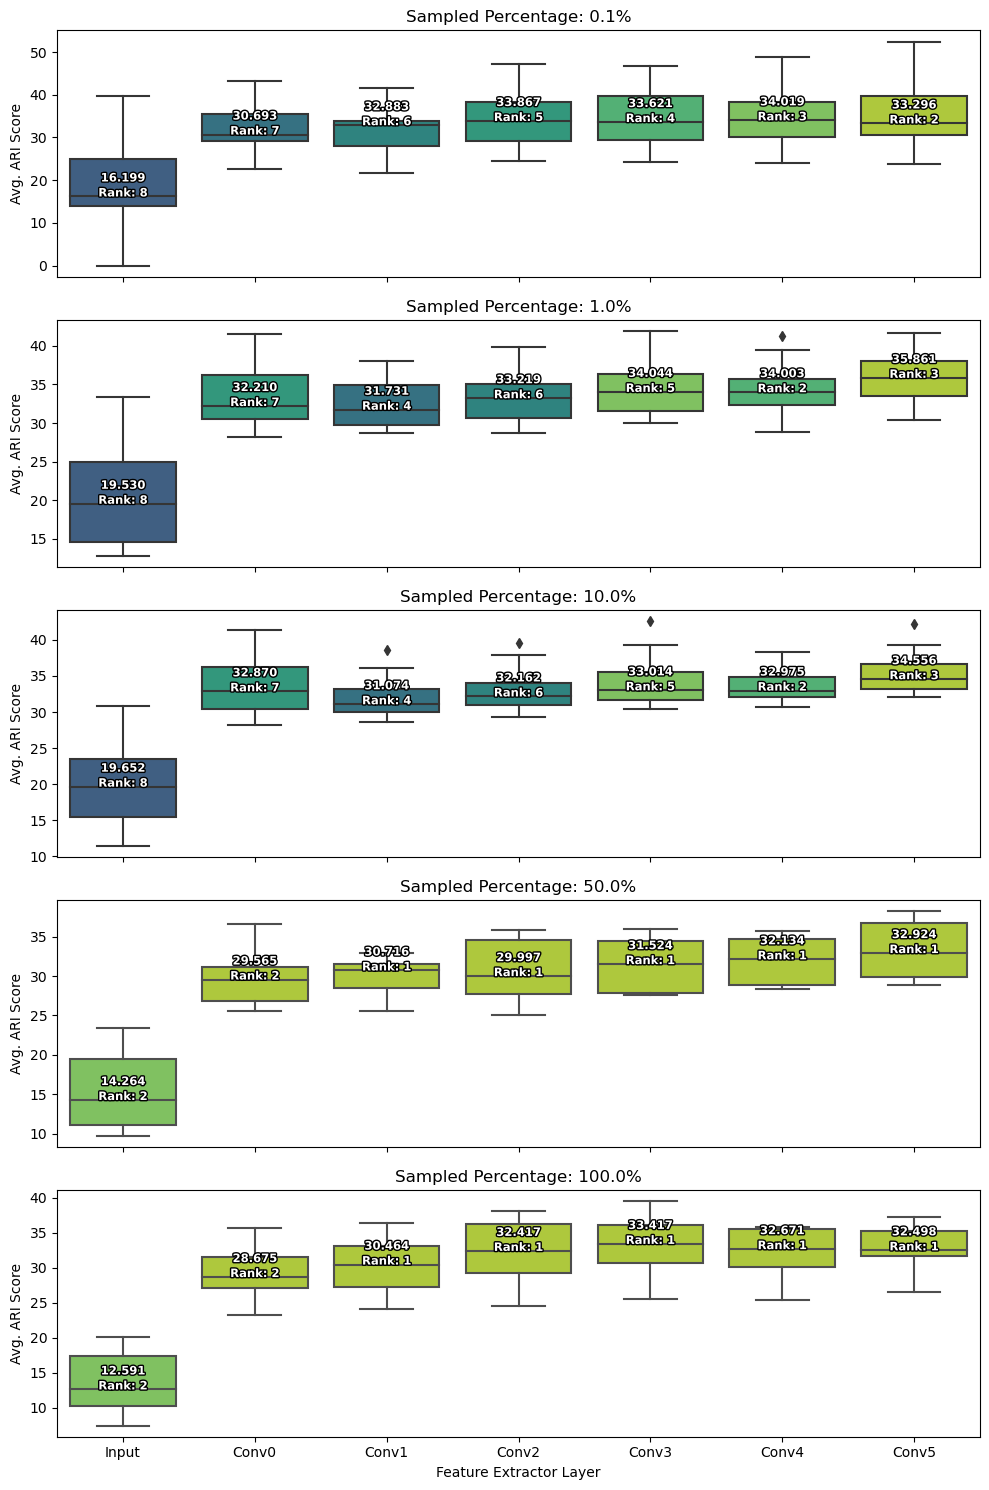

In [84]:
# run statistical tests below to get the df_rankings
_, df_rankings = get_rankings(df=df_ari)
df_ari_filtered = df_ari[df_ari['Layer'] != "fc"]
box_plot(df=df_ari_filtered, rank_df=df_rankings, params=params, add_baseline=False, tick_labels_dict=tick_labels_dict)

# 2. Statistical Tests

### Pairwise Comparison between two plots

In [26]:
# create df_rankings_empirical and df_rankings_truncated, where if one is significantly different from each other we compare the mean_test_acc of both, and the one which is bigger is ranked 1, the lower is rank 3, and if they are not significantly different they ar eboth rank 2
df_wilcoxon_pairwise = pairwise_comparison_multiple_plots(df_empirical, df_other)
stats_empirical = calculate_statistics(df_empirical)
stats_other = calculate_statistics(df_other)

df_rankings_empirical = stats_empirical.copy()
df_rankings_other = stats_other.copy()

# in a for loop, compare the is_significant of two dataframes
for i in range(len(df_wilcoxon_pairwise)):
    if df_wilcoxon_pairwise.iloc[i]['is_significant']:
        if stats_empirical.iloc[i]['Mean Test Accuracy'] > stats_other.iloc[i]['Mean Test Accuracy']:
            df_wilcoxon_pairwise.loc[i, "Higher"] = "truncate=False"
        else:
            df_wilcoxon_pairwise.loc[i, "Higher"] = "truncate=True"
        # print(df_wilcoxon_pairwise)
    else:
        df_wilcoxon_pairwise.loc[i, "Higher"] = "None"

# every row: is the percentage and cut significantly different between the two box plots
df_wilcoxon_pairwise["statistic"] = df_wilcoxon_pairwise["statistic"].astype(int)

latex_table = df_wilcoxon_pairwise.to_latex(index=False, float_format="%.6f")
rows = latex_table.split("\n")[4:-3]
header = latex_table.split("\n")[:4]
footer = latex_table.split("\n")[-3:]

# iterate over the rows and the df_wilcoxon_pairwise
for i, row in enumerate(rows):
    row = row.split(" & ")
    row = " & ".join([str(float(row[0].lstrip())*100)[:5]] + row[1:4] + row[-1:])
    if df_wilcoxon_pairwise.iloc[i]["is_significant"]:
        # split row with respect to " & ", take the 5th value, encapsulate it in \textbf{} and join them back
        row = "\\rowcolor{green!20}\n" + row
    rows[i] = row

# join the header, rows and footer, putting a "\\" at the end of each row
latex_table = "\n".join(rows)

In [27]:
print(latex_table)

0.1 &         -1 &          0 & 1.000000 &          None \\
0.1 &          0 &        117 & 0.230361 &          None \\
\rowcolor{green!20}
0.1 &          1 &         74 & 0.015973 &  reinit=False \\
0.1 &          2 &        146 & 0.672075 &          None \\
\rowcolor{green!20}
0.1 &          3 &         84 & 0.034174 &  reinit=False \\
0.1 &          4 &        162 & 1.000000 &          None \\
0.1 &          5 &        121 & 0.275184 &          None \\
0.1 &          6 &          0 & 1.000000 &          None \\
1.0 &         -1 &          0 & 1.000000 &          None \\
\rowcolor{green!20}
1.0 &          0 &          6 & 0.000001 &  reinit=False \\
\rowcolor{green!20}
1.0 &          1 &          1 & 0.000000 &  reinit=False \\
\rowcolor{green!20}
1.0 &          2 &         71 & 0.012466 &  reinit=False \\
1.0 &          3 &         93 & 0.062626 &          None \\
\rowcolor{green!20}
1.0 &          4 &         66 & 0.008069 &   reinit=True \\
1.0 &          5 &        137 & 0.507704

### Tables for Ranking Cuts

In [86]:
df_wilcoxon_pairwise, _ = get_rankings(df=df_ari)

df_wilcoxon_pairwise["statistic"] = df_wilcoxon_pairwise["statistic"].astype(int)

latex_table = df_wilcoxon_pairwise.to_latex(index=False, float_format="%.6f")
# print(latex_table)
# TODO: next, \text{p-value if significant}
# iterate over both the rows in the latex table string and the df_wilcoxon_pairwise
# if the row is significant, add the p-value to the latex table string
rows = latex_table.split("\n")[4:-3]
header = latex_table.split("\n")[:4]
footer = latex_table.split("\n")[-3:]

# iterate over the rows and the df_wilcoxon_pairwise
for i, row in enumerate(rows):
    # print(row)
    row = row.split(" & ")   
    # print(float(row[0].lstrip())*100)
    row = " & ".join([str(float(row[0].lstrip())*100)[:5]] + row[1:-1])
    if df_wilcoxon_pairwise.iloc[i]["is_significant"]:
        row = "\\rowcolor{green!20}\n" + row
    
    rows[i] = row + " \\\\"

# join the header, rows and footer, putting a "\\" at the end of each row
latex_table = "\n".join(rows)

[ 1  2  3  4  5  6 -1  0]
[ 1  2  3  4  5  6 -1  0]
[ 1  2  3  4  5  6 -1  0]
[ 1  2  3  4  5  6 -1  0]
[ 1  2  3  4  5  6 -1  0]
     Percentage  Cut Point 1  Cut Point 2  statistic       p_value
0         0.001            1            2        0.0  5.960464e-08
1         0.001            1            3        0.0  5.960464e-08
2         0.001            1            4        0.0  5.960464e-08
3         0.001            1            5        0.0  5.960464e-08
4         0.001            1            6        0.0  5.960464e-08
..          ...          ...          ...        ...           ...
135       1.000            5           -1        0.0  6.250000e-02
136       1.000            5            0        0.0  6.250000e-02
137       1.000            6           -1        0.0  6.250000e-02
138       1.000            6            0        0.0  6.250000e-02
139       1.000           -1            0        0.0  6.250000e-02

[140 rows x 5 columns]


In [88]:
print(latex_table)

\rowcolor{green!20}
0.1 & 1 & 2 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 1 & 3 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 1 & 4 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 1 & 5 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 1 & 6 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 1 & -1 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 1 & 0 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 2 & 3 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 2 & 4 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 2 & 5 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 2 & 6 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 2 & -1 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 2 & 0 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 3 & 4 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 3 & 5 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 3 & 6 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 3 & -1 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 3 & 0 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 4 & 5 & 0 & 0.000000 \\
\rowcolor{green!20}
0.1 & 4 & 6 & 0 & 0.000000 

# 3. Extras
Don't forget to change the flags to the correct ones for the titles in the params!

### Extra 1: Split the dictionaries into baseline and fine-tuning one
only run when necessary

In [14]:
with open('results/results_freeze_True_reinit_True_pool_False_random_classes.json', 'r') as f:
    data_dicts = json.load(f)

params = data_dicts[0]
baselines = [params]
results = [params]
for row in data_dicts[1:]:
    if row["sampled_cut_point"] == -1:
        baselines.append(row)
    else:
        results.append(row)

with open(f'results/baselines_freeze_True_reinit_True_pool_False_truncate_False_3_layers_random_classes.json', 'w') as f:
    json.dump(baselines, f)
with open(f'results/results_freeze_True_reinit_True_pool_False_truncate_False_3_layers_random_classes.json', 'w') as f:
    json.dump(results, f)